In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import shap
from scipy.stats import ttest_ind, f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
import uuid

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("/content/Complete_Variance_Report_Waste_2022.xlsx")
df

,Category,Inventory_Item,Pack_Size,Price_Per_Unit,Open_Count,Purchases,Transfers,Close_Count,Actual_Units,Theoretical_Units,Waste_Units,Variance_Units,Actual_Cost,Theoretical_Cost,Waste_Cost,$ Var,Variance_Percentage
0,Hot Beverages,Coffee - Original\nBlend,Case/144,120.66,2.00,0.00,281.59,2.50,281.09,310.92,0.68,-30.51,34618.44,16020.40,22.70,18575.34,2.42
1,Iced Beverage Bases,Iced Capp Java\nConcentrate,Case/6x64oz,75.06,0.34,0.00,137.76,0.50,137.60,139.60,0.84,-2.84,9045.35,3692.09,46.02,5307.24,0.69
2,Cups & Lids - Hot Beverages,Cup - Hot\nBeverage - Large,Case/1000,108.24,0.50,0.00,95.95,1.15,95.30,109.09,0.00,-13.79,8910.77,3891.13,0.00,5019.64,0.65
3,Fluid Dairy & Dairy Alternatives,Cream - 10L,Bag,32.44,15.26,1201.14,70.18,9.15,1277.42,1150.40,0.00,127.02,36387.68,32736.84,0.00,3650.84,0.48
4,Hot Beverages,Coffee - Dark\nRoast,Case/108 x 3.0 oz,108.68,1.00,0.00,53.42,1.00,53.42,38.33,0.34,14.76,5912.56,2468.07,16.78,3427.71,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Toppings & Ingredients,Topping - Praline\nPumpkin Seeds,Case/5lb,43.18,0.00,0.00,1.31,0.00,1.31,0.25,1.72,-0.66,56.45,11.02,15.49,29.94,0.00
203,Toppings & Ingredients,Topping -\nToasted Coconut,Case/25lb,65.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.00
204,Uniforms,Disposable Face\nMask,Case/50,8.39,0.50,0.00,1.00,0.00,1.50,1.50,0.00,0.00,12.54,12.54,0.00,0.00,0.00
205,Uniforms,Hairnets -\nRegular,Box/144,20.42,1.00,0.00,8.01,1.25,7.76,7.76,0.00,0.00,155.12,155.12,0.00,0.00,0.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Category             207 non-null    object 
 1   Inventory_Item       207 non-null    object 
 2   Pack_Size            207 non-null    object 
 3   Price_Per_Unit       207 non-null    float64
 4   Open_Count           207 non-null    float64
 5   Purchases            207 non-null    float64
 6   Transfers            207 non-null    float64
 7   Close_Count          207 non-null    float64
 8   Actual_Units         207 non-null    float64
 9   Theoretical_Units    207 non-null    float64
 10  Waste_Units          207 non-null    float64
 11  Variance_Units       207 non-null    float64
 12  Actual_Cost          207 non-null    float64
 13  Theoretical_Cost     207 non-null    float64
 14  Waste_Cost           207 non-null    float64
 15  $ Var                207 non-null    flo

In [6]:
df = df.fillna(0)
numeric_cols = ['Price_Per_Unit', 'Open_Count', 'Purchases', 'Transfers', 'Close_Count',
                'Actual_Units', 'Theoretical_Units', 'Waste_Units', 'Variance_Units',
                'Actual_Cost', 'Theoretical_Cost', 'Waste_Cost', 'Variance_Percentage']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# **1. Feature Importance for Waste Drivers**

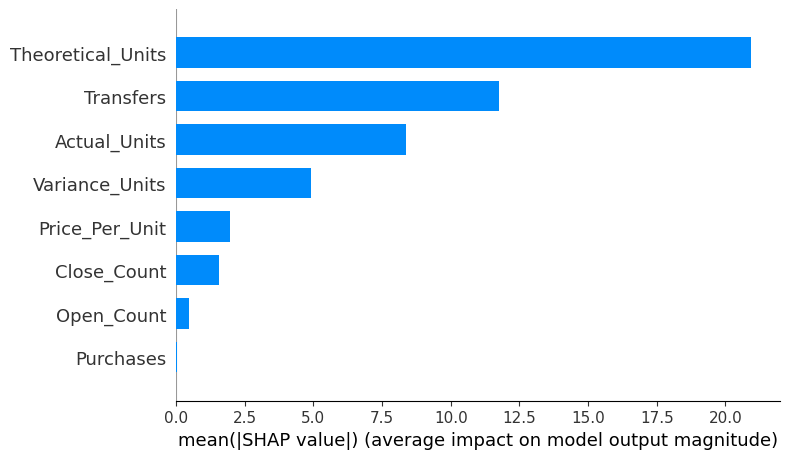

Feature Importance:
             Feature  Importance
6  Theoretical_Units    0.305269
3          Transfers    0.241035
5       Actual_Units    0.216174
7     Variance_Units    0.157749
0     Price_Per_Unit    0.065233
4        Close_Count    0.011722
1         Open_Count    0.002749
2          Purchases    0.000069


In [13]:
X = df[['Price_Per_Unit', 'Open_Count', 'Purchases', 'Transfers', 'Close_Count',
        'Actual_Units', 'Theoretical_Units', 'Variance_Units']]
y = df['Waste_Cost']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, plot_type="bar")
plt.savefig('feature_importance.png')
plt.close()

importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(importance)

# 2. **Waste Cost Prediction**

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

In [26]:
# Feature Engineering
df['Waste_to_Actual_Ratio'] = df['Waste_Units'] / (df['Actual_Units'] + 1e-6)
df['Variance_to_Actual_Ratio'] = df['Variance_Units'] / (df['Actual_Units'] + 1e-6)
df['Pack_Size_Numeric'] = df['Pack_Size'].str.extract(r'(\d+\.?\d*)').astype(float)
df['Pack_Size_Numeric'] = df['Pack_Size_Numeric'].fillna(df['Pack_Size_Numeric'].median())
category_waste = df.groupby('Category')['Waste_Cost'].mean().to_dict()
df['Category_Waste_Rate'] = df['Category'].map(category_waste)
df['Inventory_Turnover'] = (df['Purchases'] + df['Transfers']) / (df['Open_Count'] + df['Close_Count'] + 1e-6)
df['Stock_Discrepancy'] = df['Actual_Units'] - df['Theoretical_Units']
df['Unit_Cost_Impact'] = df['Price_Per_Unit'] * df['Waste_Units']
df['Has_Waste'] = (df['Waste_Units'] > 0).astype(int)
df['Negative_Variance'] = (df['Variance_Units'] < 0).astype(int)
df = df.replace([np.inf, -np.inf], 0)

In [19]:
# Log transform the target to handle skewness
df['Log_Waste_Cost'] = np.log1p(df['Waste_Cost'])

In [20]:
X = df[['Price_Per_Unit', 'Open_Count', 'Purchases', 'Transfers', 'Close_Count',
        'Actual_Units', 'Theoretical_Units', 'Variance_Units',
        'Waste_to_Actual_Ratio', 'Variance_to_Actual_Ratio', 'Pack_Size_Numeric',
        'Category_Waste_Rate', 'Inventory_Turnover', 'Stock_Discrepancy', 'Unit_Cost_Impact']]
y = df['Log_Waste_Cost']  # Use log-transformed target

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for Linear Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred_log = rf.predict(X_test)
rf_pred = np.expm1(rf_pred_log)


# Evaluate models
print("Waste Cost Prediction Metrics (on original scale):")
print(f"Random Forest - R²: {r2_score(y_test_orig, rf_pred):.4f}, RMSE: {np.sqrt(mean_squared_error(y_test_orig, rf_pred)):.4f}")

Waste Cost Prediction Metrics (on original scale):
Random Forest - R²: 0.8846, RMSE: 6.8034


# **3. Hypothesis Validation (Integrated with ML)**

In [41]:
from scipy.stats import ttest_ind, chi2_contingency

In [42]:
df['Waste_Risk'] = (df['Waste_Cost'] > df['Waste_Cost'].median()).astype(int)
df['Pack_Size_Numeric'] = df['Pack_Size'].str.extract(r'(\d+\.?\d*)').astype(float)
df['Pack_Size_Numeric'] = df['Pack_Size_Numeric'].fillna(df['Pack_Size_Numeric'].median())

#### Hypothesis: **Statement: Items with smaller pack sizes have lower waste costs compared to items with larger pack sizes.**

**Null Hypothesis:** There is no significant difference in Waste_Cost between items with smaller pack sizes and items with larger pack sizes

**Alternate Hypothesis:** Items with smaller pack sizes have a lower Waste_Cost compared to items with larger pack sizes

In [44]:
# Hypothesis 1: Smaller Pack_Size leads to lower Waste_Cost
pack_size_median = df['Pack_Size_Numeric'].median()
small_pack = df[df['Pack_Size_Numeric'] <= pack_size_median]['Waste_Cost']
large_pack = df[df['Pack_Size_Numeric'] > pack_size_median]['Waste_Cost']
t_stat, p_val = ttest_ind(small_pack.dropna(), large_pack.dropna())

print(f"T-test p-value: {p_val:.4f}")
if p_val < 0.05:
    print("Result: Significant difference - smaller pack sizes may lead to lower waste cost.")
else:
    print("Result: No significant difference - pack size may not strongly influence waste cost.")

T-test p-value: 0.0001
Result: Significant difference - smaller pack sizes may lead to lower waste cost.
